
# DS3010: Introduction to Machine Learning Lab – Week 5
## **Logistic Regression (from scratch) and Naive Bayes Classification**
**Name:** Parv Patel  
**Roll No:** 142301041  
**Lab:** Week 5 – Logistic Regression & Naive Bayes  

---

### Objective
- Implement logistic regression from scratch using NumPy and train it on the Heart Failure Prediction dataset.  
- Train and evaluate a Gaussian Naive Bayes classifier using scikit-learn.  
- Compare results and interpret them.

**Notes:** All steps follow the lab instructions. The notebook contains preprocessing, training, plotting, evaluation metrics, and concise discussion.


## 1. Logistic Regression from Scratch

### 1(a) Data Preprocessing
1. Load dataset and inspect for missing values and types.
2. Encode categorical variables using LabelEncoder.
3. Standardize entire feature set using StandardScaler.
4. Split into train/test (80/20, random_state=42).  
5. Reshape y_train and y_test to (-1,1).

In [1]:

# Load libraries and dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

data_path = "heart.csv"
df = pd.read_csv(data_path)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [2]:

# Inspect dataset: columns, dtypes, missing values
print("Columns:", df.columns.tolist())
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())

Columns: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']

Data types:
 Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Missing values per column:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [3]:

# Identify categorical columns mentioned in the lab instructions (if present)
# We'll detect object / categorical dtypes automatically and then narrow to the listed ones if they exist.
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns detected:", categorical_cols)

# Lab mentions these specific categorical features:
expected_cats = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
present_expected = [c for c in expected_cats if c in df.columns]
print("Expected categorical columns present in dataset:", present_expected)

Categorical columns detected: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Expected categorical columns present in dataset: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [4]:

# Use LabelEncoder for categorical columns (Logistic from scratch section)
le = LabelEncoder()
df_encoded = df.copy()
for col in present_expected:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Show transformed dataset head
df_encoded.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [5]:

# Separate features and target. Find likely target column name (common name 'HeartDisease' or 'target' or 'output').
# We'll attempt to detect a binary column with name hints.
possible_targets = [c for c in df_encoded.columns if c.lower() in ['target', 'heartdisease', 'heart_disease', 'output', 'death_event', 'cardio']]
print("Possible target column names found:", possible_targets)
print("\nAll column names:", df_encoded.columns.tolist())

Possible target column names found: ['HeartDisease']

All column names: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


In [6]:

# If a clear target not found by heuristic, let user know and pick a binary column heuristically
if len(possible_targets) == 0:
    # Try to find columns with only 0/1 values
    binary_cols = [c for c in df_encoded.columns if sorted(df_encoded[c].unique()) in ([0,1], [0,1, np.nan]) or set(df_encoded[c].dropna().unique()).issubset({0,1})]
    print("Binary-like columns detected:", binary_cols)
    # We'll choose 'HeartDisease' if exists, else the first binary-like column
    if 'HeartDisease' in df_encoded.columns:
        target_col = 'HeartDisease'
    elif len(binary_cols) > 0:
        target_col = binary_cols[0]
    else:
        # As a last resort, ask to use column 'target' if present
        if 'target' in df_encoded.columns:
            target_col = 'target'
        else:
            # fallback: print df.info
            raise ValueError("Could not automatically detect binary target column. Inspect the dataset and rerun. Columns: " + ','.join(df_encoded.columns))
else:
    target_col = possible_targets[0]

print('Selected target column:', target_col)

Selected target column: HeartDisease


In [7]:

# Prepare X, y
X = df_encoded.drop(columns=[target_col]).copy()
y = df_encoded[target_col].copy()

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)
print("\nTarget value counts:\n", y.value_counts())

Feature matrix shape: (918, 11)
Target shape: (918,)

Target value counts:
 HeartDisease
1    508
0    410
Name: count, dtype: int64


In [8]:

# Feature scaling: Standardize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.2, random_state=42, stratify=y.values)
# reshape y to (-1,1)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (734, 11) (734, 1)
Test shapes: (184, 11) (184, 1)


### 1(b) Core Implementation (from scratch using NumPy)
Implement:
- sigmoid
- initialize_parameters
- compute_cost (with L2 regularization)
- optimize (gradient descent)
- predict

In [9]:

# Logistic Regression from scratch with L2 regularization
class LogisticRegressionScratch:
    def __init__(self, lr=0.1, num_iter=2000, reg_lambda=0.01, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.reg_lambda = reg_lambda
        self.fit_intercept = fit_intercept
        self.verbose = verbose
        self.w = None  # weights (including intercept if fit_intercept)
        self.costs = []
    
    def _add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def sigmoid(self, z):
        # numerical stability
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def initialize_parameters(self, dim):
        # Initialize weights to zeros; dim is number of features (with intercept removed)
        if self.fit_intercept:
            self.w = np.zeros((dim + 1, 1))
        else:
            self.w = np.zeros((dim, 1))
    
    def compute_cost(self, X, y):
        # X is (n, d) already with intercept if used; y is (n,1)
        n = X.shape[0]
        z = X.dot(self.w)  # (n,1)
        p = self.sigmoid(z)
        # clip p to avoid log(0)
        eps = 1e-9
        p = np.clip(p, eps, 1 - eps)
        # logistic loss (binary cross-entropy)
        loss = - (1/n) * np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
        # L2 regularization (exclude intercept term if present)
        if self.fit_intercept:
            w_no_intercept = self.w[1:]
        else:
            w_no_intercept = self.w
        reg = self.reg_lambda * np.sum(w_no_intercept ** 2)
        return loss + reg
    
    def optimize(self, X, y):
        # X: (n, d) without intercept (we will add), y: (n,1)
        if self.fit_intercept:
            X = self._add_intercept(X)
        n = X.shape[0]
        self.initialize_parameters(X.shape[1] - (1 if self.fit_intercept else 0))
        
        for i in range(self.num_iter):
            z = X.dot(self.w)  # (n,1)
            p = self.sigmoid(z)
            # gradient: (1/n) * X^T (p - y) + 2 * lambda * w_no_intercept_term
            grad = (1/n) * X.T.dot(p - y)  # (d,1)
            if self.fit_intercept:
                # add regularization only for weights excluding intercept
                reg = np.concatenate((np.zeros((1,1)), 2 * self.reg_lambda * self.w[1:]), axis=0)
            else:
                reg = 2 * self.reg_lambda * self.w
            grad = grad + reg
            # update weights
            self.w = self.w - self.lr * grad
            # store cost
            cost = self.compute_cost(X, y)
            self.costs.append(cost)
            if self.verbose and i % 200 == 0:
                print(f"Iteration {i}, cost {cost:.6f}")
        return self.w, self.costs
    
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self._add_intercept(X)
        z = X.dot(self.w)
        return self.sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        probs = self.predict_prob(X)
        return (probs >= threshold).astype(int)

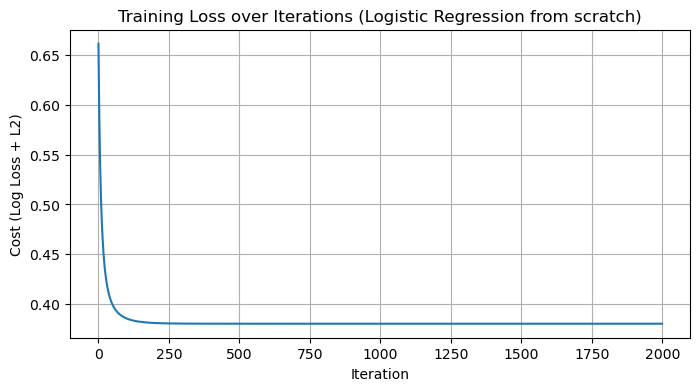

In [10]:

# Train logistic regression from scratch
model = LogisticRegressionScratch(lr=0.1, num_iter=2000, reg_lambda=0.01, verbose=False)
model.optimize(X_train, y_train)

# Plot cost over iterations
plt.figure(figsize=(8,4))
plt.plot(model.costs)
plt.xlabel('Iteration')
plt.ylabel('Cost (Log Loss + L2)')
plt.title('Training Loss over Iterations (Logistic Regression from scratch)')
plt.grid(True)
plt.show()

In [11]:

# Predictions and evaluation
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# compute accuracies
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy (scratch): {train_acc:.4f}")
print(f"Test Accuracy (scratch): {test_acc:.4f}")

Train Accuracy (scratch): 0.8542
Test Accuracy (scratch): 0.8750


In [12]:

# Confusion matrix for test set
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test set):\n", cm)

# Additional metrics
precision = precision_score(y_test, y_test_pred, zero_division=0)
recall = recall_score(y_test, y_test_pred, zero_division=0)
f1 = f1_score(y_test, y_test_pred, zero_division=0)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Confusion Matrix (Test set):
 [[67 15]
 [ 8 94]]
Precision: 0.8624, Recall: 0.9216, F1: 0.8910


## 2. Naive Bayes Classification with Scikit-Learn

### 2(a) Data Preprocessing (No scaling; OneHotEncode categorical features)
- Do not perform feature scaling.
- Use OneHotEncoder for categorical features instead of LabelEncoder.
- Split into train/test 80/20 (random_state=42).

In [13]:

# For Naive Bayes we reload original dataframe (no label encoding before)
df_nb = pd.read_csv(data_path)
df_nb.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [14]:

# Identify categorical columns to OneHotEncode. We'll use the previously detected expected_cats that exist.
categorical_cols_nb = present_expected  # from earlier cells; if empty this will be empty
print('Categorical columns to one-hot encode:', categorical_cols_nb)

Categorical columns to one-hot encode: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import sklearn

# If categorical columns exist, apply OneHotEncoder; else use numerical features as-is
X_nb = df_nb.drop(columns=[target_col]).copy()
y_nb = df_nb[target_col].copy()

# Automatically handle version differences in scikit-learn
if len(categorical_cols_nb) > 0:
    try:
        # For scikit-learn >= 1.2
        ct = ColumnTransformer(
            [('onehot', OneHotEncoder(sparse_output=False, drop='first'), categorical_cols_nb)],
            remainder='passthrough'
        )
    except TypeError:
        # For scikit-learn < 1.2
        ct = ColumnTransformer(
            [('onehot', OneHotEncoder(sparse=False, drop='first'), categorical_cols_nb)],
            remainder='passthrough'
        )

    X_transformed = ct.fit_transform(X_nb)
else:
    X_transformed = X_nb.values

print(f"scikit-learn version: {sklearn.__version__}")
print('Shape after one-hot (or passthrough):', X_transformed.shape)


scikit-learn version: 1.7.2
Shape after one-hot (or passthrough): (918, 15)


In [18]:

# Train-test split for Naive Bayes (no scaling)
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_transformed, y_nb.values, test_size=0.2, random_state=42, stratify=y_nb.values)
print('Train shape:', X_train_nb.shape, 'Test shape:', X_test_nb.shape)

Train shape: (734, 15) Test shape: (184, 15)


GaussianNB Test Accuracy: 0.9130

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90        82
           1       0.93      0.91      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184



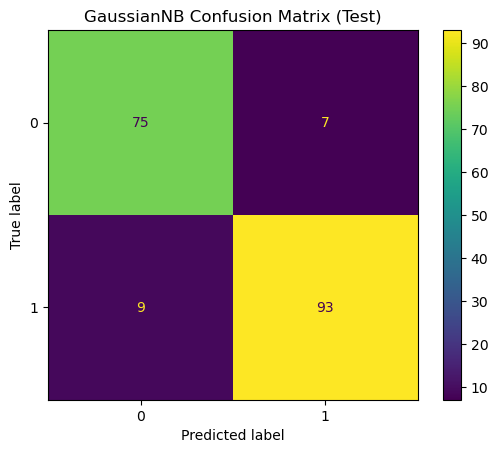

Predicted probabilities for first 10 test samples:
 [[5.05280257e-06 9.99994947e-01]
 [9.16471536e-01 8.35284639e-02]
 [1.02716786e-05 9.99989728e-01]
 [7.06161625e-02 9.29383838e-01]
 [9.88778108e-01 1.12218921e-02]
 [8.98664703e-01 1.01335297e-01]
 [9.99999928e-01 7.21767191e-08]
 [1.59448691e-01 8.40551309e-01]
 [9.99989280e-01 1.07203691e-05]
 [9.88927808e-06 9.99990111e-01]]


In [19]:

# 2(b) Train GaussianNB and evaluate
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

gnb = GaussianNB()
gnb.fit(X_train_nb, y_train_nb)

y_pred_nb = gnb.predict(X_test_nb)
y_proba_nb = gnb.predict_proba(X_test_nb)

acc_nb = accuracy_score(y_test_nb, y_pred_nb)
print(f'GaussianNB Test Accuracy: {acc_nb:.4f}\n')

# Precision, recall, f1
print('Classification Report:\n', classification_report(y_test_nb, y_pred_nb, zero_division=0))


# Confusion matrix visualization
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_nb, y_pred_nb))
disp.plot()
plt.title('GaussianNB Confusion Matrix (Test)')
plt.show()

# Predicted probabilities for first 10 test samples
print('Predicted probabilities for first 10 test samples:\n', y_proba_nb[:10])

In [20]:

# Compare Naive Bayes accuracy with logistic from scratch
print(f'Logistic (scratch) Test Accuracy: {test_acc:.4f}')
print(f'GaussianNB Test Accuracy:     {acc_nb:.4f}')

Logistic (scratch) Test Accuracy: 0.8750
GaussianNB Test Accuracy:     0.9130



### Analysis and Comparison

1. Compare test accuracy between Naive Bayes and Logistic Regression (from scratch).  

2. Discuss the 'naive' independence assumption and why Naive Bayes can perform well despite violations.


**(Short answers prepared in the next cell)**


In [21]:

# Short answers / discussion
print('Comparison:') 
if acc_nb > test_acc:
    print('GaussianNB performed better on test accuracy.')
elif acc_nb < test_acc:
    print('Logistic Regression (scratch) performed better on test accuracy.')
else:
    print('Both models achieved similar test accuracy.')

print('\nOn the independence assumption:') 
print('The features in the dataset are unlikely to be truly independent (e.g., age, cholesterol, max heart rate).')
print('Despite this, Naive Bayes often works well in practice because it estimates class-conditional likelihoods independently which can still produce effective decision boundaries, is robust with small data, and is less sensitive to irrelevant features. Regularization and proper encoding also help.')


Comparison:
GaussianNB performed better on test accuracy.

On the independence assumption:
The features in the dataset are unlikely to be truly independent (e.g., age, cholesterol, max heart rate).
Despite this, Naive Bayes often works well in practice because it estimates class-conditional likelihoods independently which can still produce effective decision boundaries, is robust with small data, and is less sensitive to irrelevant features. Regularization and proper encoding also help.
